In [1]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down');

<IPython.core.display.Javascript object>

# Introduction:
Being anonymous over the internet can sometimes make people say nasty things that they normally would not in real life.
Let's filter out the hate from our platforms one comment at a time. 

## Objective:
To create an EDA/ feature-engineering starter notebook for toxic comment classification.

## Data Overview:
The dataset here is from wiki corpus dataset which was rated by human raters for toxicity.
The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015. 

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories
* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

The tagging was done via **crowdsourcing** which means that the dataset was rated by different people and the tagging might not be 100% accurate too. The same concern is being discussed [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/46131).

The [source paper](https://arxiv.org/pdf/1610.08914.pdf) also contains more interesting details about the dataset creation.

## Note:
A [New test dataset](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/46177) is being created by the organizers as the test set labels are present [here](https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973).

The kernal has been updated for the new data.

In [2]:
import pylab

In [3]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#vizualization packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib_venn as venn

#nlp- natural language processing
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split



#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [4]:
#importing the dataset
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [5]:
#take a peak
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [8]:
#to know the distibution of data between train and test lets add the train and test records and know the precentage of each

nrow_train=train.shape[0]
#the shape will print the dimensions of dataframe and [0] will print the number of rows
nrow_test=test.shape[0]

sum=nrow_train+nrow_test
#summing the number of train rows and number of test rows
print("       : train : test") #printing
print("rows   :",nrow_train,":",nrow_test) #printing nuber of train and test rows
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum)) #taking the percentage of train and test rows by 
#dividing the number of train and test records with sum and multiplying with 100 which gives percentage

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


There is a 51:49 train: test split

### Class Imbalance:
There might be more number of clean messages than abusive so it must be class imbalance

In [10]:
x=train.iloc[:,2:].sum() #take all the records iloc[:,] and take all columns starting from 3rd iloc[:,2:] and sum will 
#take the sum of each column i.e if a particular message is toxic then there will be value 1 in toxic column of that row.
#by summing each column we will know the frequency of each type of message and storing it in x

#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1) #taking the sum of each row starting from 3rd column
#if the sum of any row is zero then that message is not classifiedinto any of the abusive that means it is a clean message

train['clean']=(rowsums==0)#now creating a new column clean which has boolean if the row has 0 value in it

#count number of clean entries
train['clean'].sum() #this will give the sum of TRUE in clean attribute
print("Total comments = ",len(train)) 
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [11]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


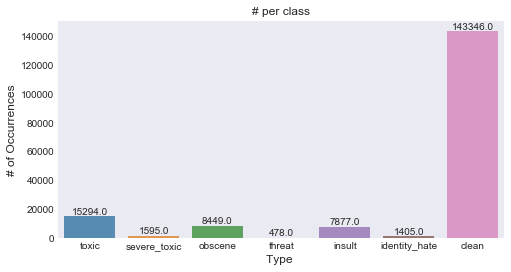

In [12]:
x=train.iloc[:,2:].sum() #taking the frequency of each category
#plot
plt.figure(figsize=(8,4))#setting figure plot size 
ax= sns.barplot(x.index, x.values, alpha=0.8) #using seaborn barplot with x-axis: index i.e the names of the attribute 
#y-axis: the frequncy
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)


#adding the text labels printing the frequency on top of each bar
rects = ax.patches  #
labels = x.values #the frequency of each category

#lopping through each value of the category along with the dimensions od the bar plot 
for rect, label in zip(rects, labels):
    height = rect.get_height() #getting the height of each category 
    ax.text(rect.get_x()+rect.get_width()/2, height + 5, label, ha='center', va='bottom') #giving the x, y co-ordinates and label contains the value 
plt.savefig('distribution_y_in_train.png')
plt.show()



* The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
* There are ~95k comments in the training dataset and there are ~21 k tags and ~86k clean comments!?
    * This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene. 

### Multi-tagging:
Let's check how many comments have multiple tags.

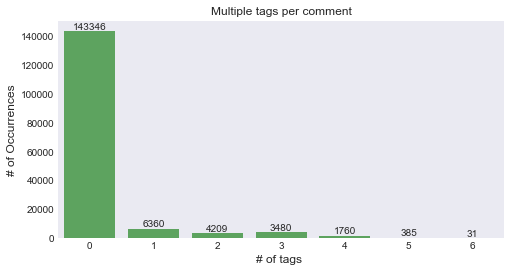

In [14]:
x=rowsums.value_counts()
#getting the frequency of number of 1 present in each record

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

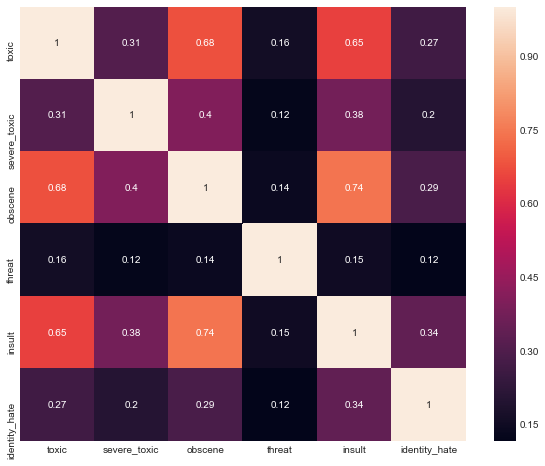

In [15]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

Only ~10% of the total comments have some sort of toxicity in them. There are certain comments(31) that are marked as all of the above!

## Which tags go together?
Now let's have a look at how often the tags occur together. A good indicator of that would be a correlation plot.

In [16]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic" #taking toxic into main column string
corr_mats=[] #creating an empty list 
for other_col in temp_df.columns[1:]: #for every column in temp_df starting from second column
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col]) #create a crosstab i.e the number of classes for toxic as number of rows
                                                                            #and frequency of the other column as columns
    corr_mats.append(confusion_matrix) #keep updating the confusion matrix so this will have toxic as rows and all other columns on right
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:]) #now corr_mats contains list of each confusion matrix
#pd.concat will convert into a dataframe and with axis=1 will convert the rows to columns

#cell highlighting
#out = out.style.apply(highlight_min,axis=0)  #applying color to the minimum value in each column
out

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes. 

Some interesting observations:

* A Severe toxic comment is always toxic
* Other classes seem to be a subset of toxic barring a few exceptions

More about cramers test can be studied at https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V



In [17]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [18]:
#Checking for Toxic and Severe toxic for now

confusion_matrix = pd.crosstab(temp_df.toxic, temp_df.severe_toxic) #creating frequencies of both toxic and severe toxic columns
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix) #giving this as input to cramers function
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)


Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.308502905405



## Example Comments:

Lets look at few messages of each class

In [19]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[8,1]) #print first column of eighth record in dataframe where toxic ==1 
#print(train[train.severe_toxic==1].iloc[5,1])

toxic:
you gay motherfucker i know where you live,i am going to sand your face off,then i am to going to beat you to a pulp,you chicken shagger.


In [20]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])
#print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [21]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])
#print(train[train.threat==1].iloc[2,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [22]:
print("Obscene:")
print(train[train.obscene==1].iloc[9,1])
#print(train[train.obscene==1].iloc[2,1])

Obscene:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [23]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])
#print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


That was a whole lot of toxicity. Some weird observations:

* Some of the comments are extremely and mere copy paste of the same thing
* Comments can still contain IP addresses(eg:62.158.73.165), usernames(eg:ARKJEDI10) and some mystery numbers(i assume is article-IDs)

Point 2 can cause huge overfitting.

# Wordclouds - Frequent words:

Now, let's take a look at words that are associated with these classes.

   Chart Desc: The visuals here are word clouds (ie) more frequent words appear bigger. A cool way to create word clouds with funky pics is given [in_this_link](https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial). It involves the following steps.
    * Search for an image and its base 64 encoding
    * Paste encoding in a cell and convert it using codecs package to image
    * Create word cloud with the new image as a mask
A simpler way would be to create a new kaggle dataset and import images from there.

In [24]:
stopword=set(STOPWORDS) #taking the stopwords into a list

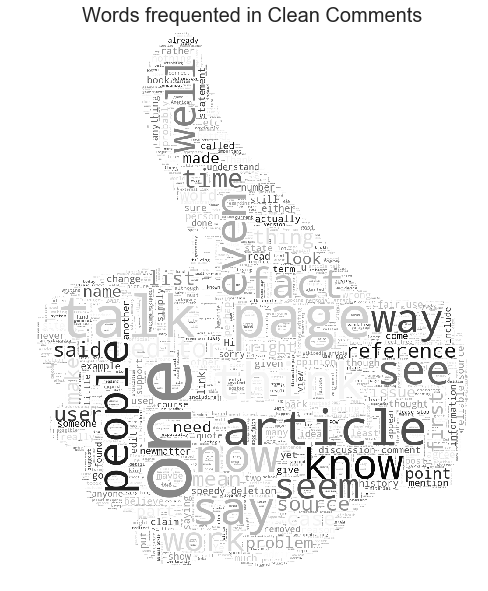

In [25]:
#clean comments
clean_mask=np.array(Image.open("safe-zone1.jpg")) #importing an image which you want ot mask it into wordcloud
safe_image_color = np.array(Image.open("safe-zone1.jpg"))
clean_mask=clean_mask[:,:,1] #taking only the last dimension of the three dimension image

#wordcloud for clean comments
subset=train[train.clean==True]#subsetting only clean tagged records

text=subset.comment_text.values #subsetting the sentences present in clean records

wc= WordCloud(background_color="white",max_words=2000,mask=clean_mask,stopwords=stopword) #initializing a wordcloud with background as black
#and maximum 2000 words and mask it with the image that we imported earlier and remove stopwords 

# create coloring from image
safe_image_color = ImageColorGenerator(safe_image_color)  #generating image color which will be used for coloring words
#https://amueller.github.io/word_cloud/auto_examples/colored.html  for more information about coloring

wc.generate(" ".join(text)) #generate wordcloud for text dataset

plt.figure(figsize=(20,10)) #dimension of the figure
plt.axis("off") #no axis labels 
plt.title("Words frequented in Clean Comments", fontsize=20) #title of the plot
plt.imshow(wc.recolor(colormap=plt.cm.gray , random_state=17), alpha=0.98) # printing in gray color with 98% OCCUPANCY
plt.savefig("clean_wordcloud")
plt.show()

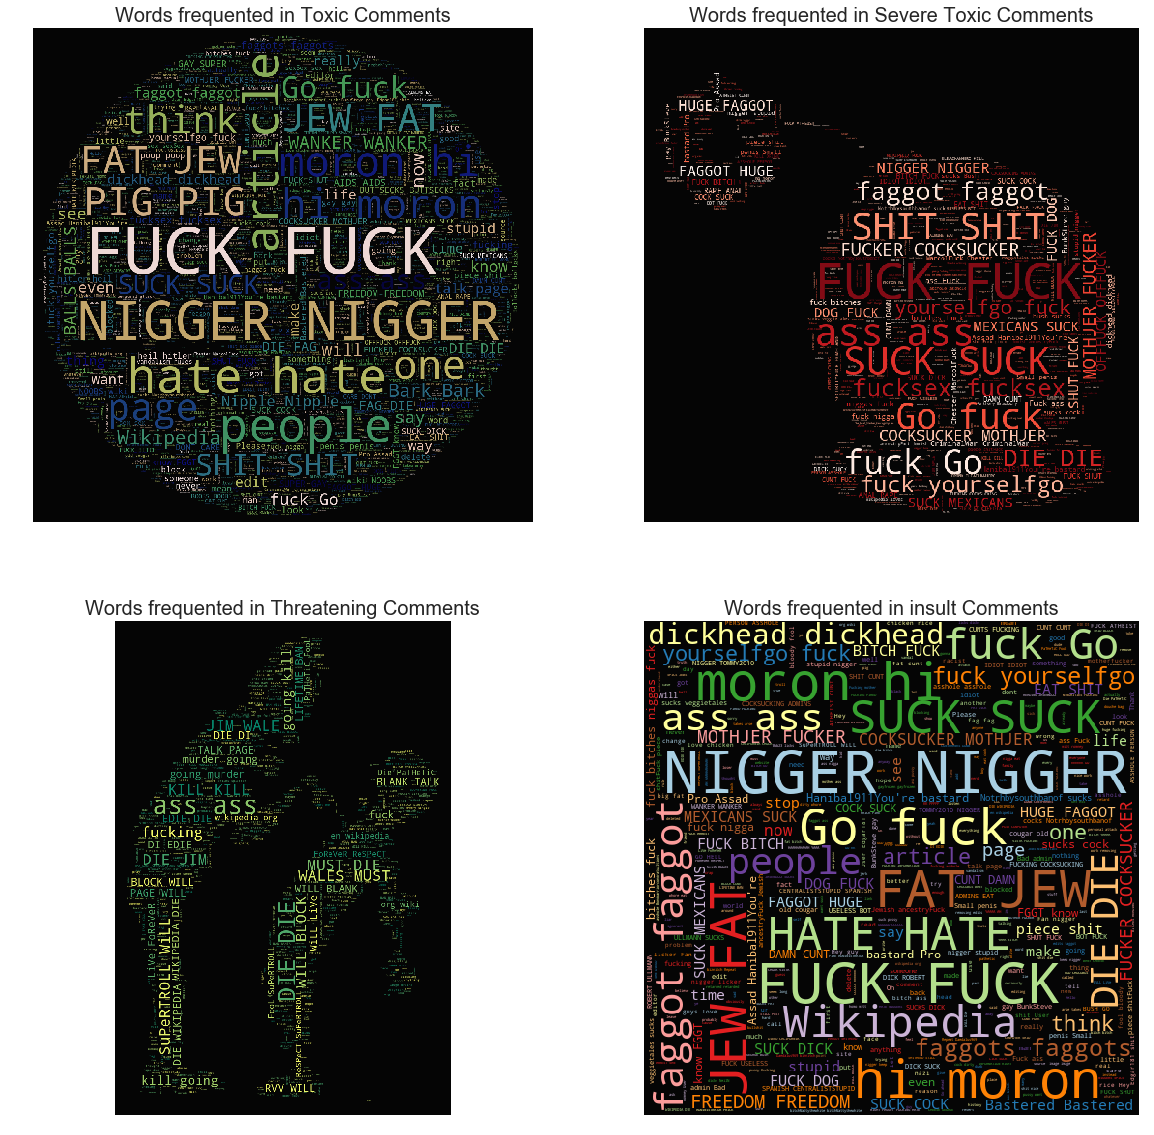

In [26]:
toxic_mask=np.array(Image.open("toxic-sign.jpg")) #open the image which you want to mask
toxic_mask=toxic_mask[:,:,1] #taking the final layer for masking
#wordcloud for clean comments
subset=train[train.toxic==1] #subsetting only those records which are classified as toxic
text=subset.comment_text.values #getting the words
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=stopword) #creating a word cloud 
wc.generate(" ".join(text)) #generating text 
plt.figure(figsize=(20,20)) #figure dimensions
plt.subplot(221) #as we are plotting multiple plots writing it as subset 
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("bomb.jpg"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("anger.jpg"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("swords.png"))
insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.savefig("toxic_text_wordcloud")
plt.show()

# Feature engineering:
I've broadly classified my feature engineering ideas into the following three groups
## Direct features:
Features which are a directly due to words/content.We would be exploring the following techniques
* Word frequency features
    * Count features
    * Bigrams
    * Trigrams
* Vector distance mapping of words (Eg: Word2Vec)
* Sentiment scores

## Indirect features:
Some more experimental features.
* count of sentences 
* count of words
* count of unique words
* count of letters 
* count of punctuations
* count of uppercase words/letters
* count of stop words
* Avg length of each word

In [26]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])  #concat the first two column of each dataframe to do text analysis
df=merge.reset_index(drop=True) #resetting the index to have a clean dataframe

In [27]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1) #this will loop throufh every record
#and counts the number of \n which represents the starting of sentence and +1 is used to count the first sentence

#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#counting the number of words in each sentence: split() will split the sentence and len() will take the length of the sentence 
#and thus adding it to the count_word column

#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#set will build the frequency of unique words and len will take the length of the set.


#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#this will count the number of letters present in each record


#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#this will check weather each letter is present in string.punctuation
#if it is present in the list then it will append in c and now we are taking the length of the C

#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#taking each word and seeing if it is uppercase and appending w and taking the length of W which will have all the uppercase words in that record

#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#taking the length of number of stopwords in each record by splitting the sentence into words and checking weather the words are present
#in stopwords and if present the w is going to append and taking length will get the list....


#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#len() wil give the length of the words


In [28]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']


#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [29]:
#separate train and test features
train_feats=df.iloc[0:len(train),]
#separating by taking the index of df from 0 to len of train

test_feats=df.iloc[len(train):,]
#taking all the records from the last record of train to the end of df

#join the tags
train_tags=train.iloc[:,2:] #take all the rows and all columns starting from 3rd

train_feats=pd.concat([train_feats,train_tags],axis=1) #adding the transformated columns and the initial data

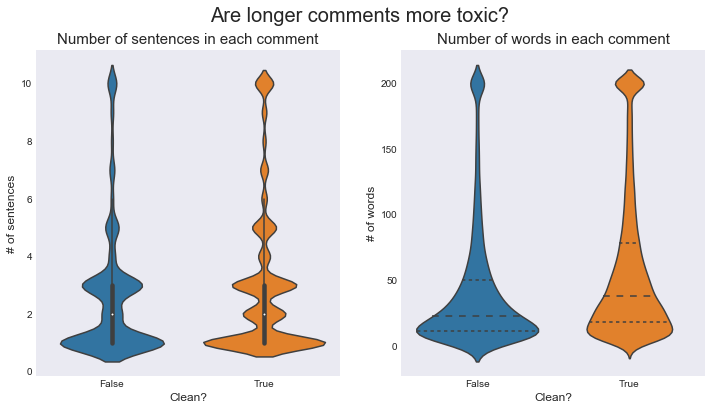

In [30]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
#replacing all the values in count_sent column which are greater than 10 by 10

plt.figure(figsize=(12,6))#set dimensions of plot

## sentenses
plt.subplot(121) #one subplot 
plt.suptitle("Are longer comments more toxic?",fontsize=20) #title of the plot
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True) #seaborn violin plot where x axis is clean column
#y-axis is count_sent 
plt.xlabel('Clean?', fontsize=12) 
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)

# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200 #replacing all the values greater than 200 by 200 to avoid skew of the plot
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)
plt.savefig("violin_plot_length_comments")
plt.show()

Long sentences or more words do not seem to be a significant indicator of toxicity.

Chart desc: Violin plot is an alternative to the traditional box plot. The inner markings show the percentiles while the width of the "violin" shows the volume of comments at that level/instance.

In [31]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#now to create a violin plot with is the message clean or not an
#and then the distribution of count_word and the distribution of count_unique_word as adjacent in violin plot
#now pd.melt will create a dataframe with one column consisting if the message is clean or not
#secnd column consisting the column having the names given in value_vars option
#third column will have the corresponding value of the value_var name


#spammers - comments with less than 30% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]
#now letscreate a df which has has than 30 unique words


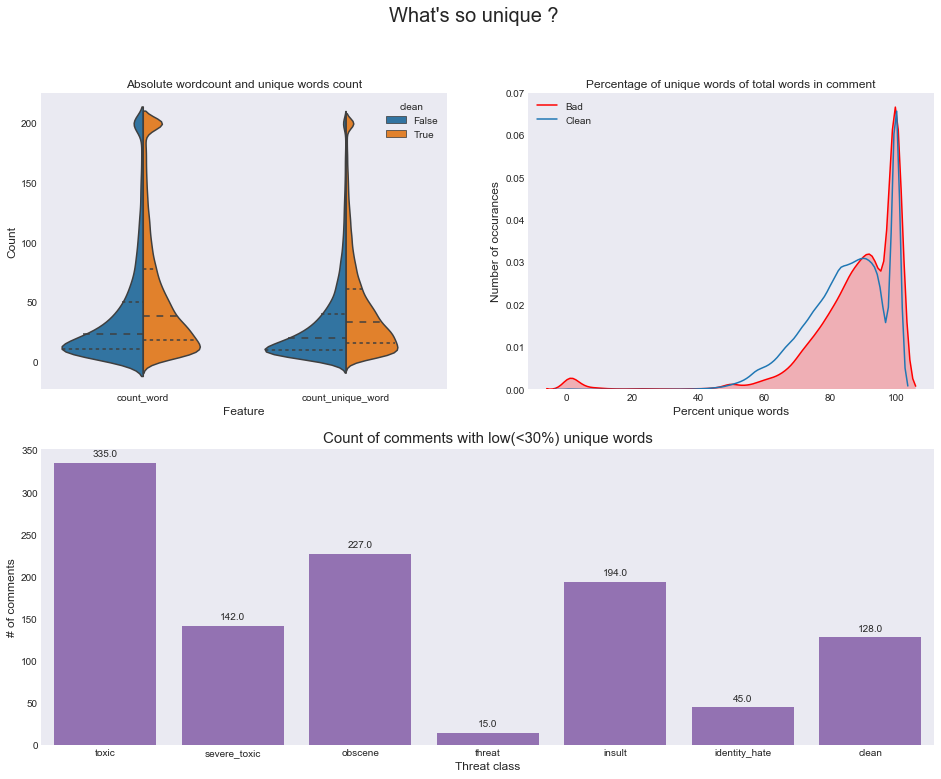

In [32]:
plt.figure(figsize=(16,12)) #figure dimensions
plt.suptitle("What's so unique ?",fontsize=20) #title of plot
gridspec.GridSpec(2,2) # create a two by two size grid
plt.subplot2grid((2,2),(0,0)) #in the created 2 by 2 grid palce thw below chart at 0,0 position
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile') #
#now creating a violin plot to understand the distribution of counnt word and count_word with hue as clean :)
plt.title("Absolute wordcount and unique words count") #the title of the plot
plt.xlabel('Feature', fontsize=12) #the x label
plt.ylabel('Count', fontsize=12) #the y label


plt.subplot2grid((2,2),(0,1)) #now plot the below at 0,1 position of 2,2 grid
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r') #
#this will plot a continues word_unique_percent of records that are not clean and we lebel it as BAD and color it as red
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean") #same is being plot for clean records
plt.legend()# plot legend inside the plot
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)


x=spammers.iloc[:,-7:].sum() #taking only the necessary columns and summing up each column this gives frequency
plt.subplot2grid((2,2),(1,0),colspan=2)# place this plot in a grid
plt.title("Count of comments with low(<30%) unique words",fontsize=15)  #title of plot
ax=sns.barplot(x=x.index, y=x.values,color=color[4])# #bar plot with index on x axis and values i.e frequency on y-axiss 


#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)

plt.savefig("unique_plots")
plt.show()

### Word count VS unique word count:
There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.
   * Chart desc: The first chart is a split violin chart. It is a variation of the traditional box chart/violin chart which allows us to split the violin in the middle based on a categorical variable.
   
### Unique word count percent:
There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.
   * Chart desc: The second chart is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments

Even though the number of clean comments dominates the dataset(~90%), there are only 75 clean comments that are spam, which makes it a powerful indicator of a toxic comment.
# Spammers are more toxic!
No surprises here. Let's take a look at some clean and toxic spam messages

In [33]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[1])
print("Toxic Spam example:")
print(spammers[spammers.toxic==1].comment_text.iloc[2])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc

# Spam is toxic to the model too!

These spam entries are bad if we design our model to contain normal word counts features.
Imagine the scenario in which our model picked up the words "mitt romney" from any comment and classified it as toxic :(


# Corpus cleaning:

Its important to use a clean dataset before creating count features. 

In [34]:
corpus=merge.comment_text  #now taking only the sentenes into corpus pandas series

In [35]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower() #this line will convert characters to lowercase
    #remove \n
    comment=re.sub("\\n","",comment) #this code will remove \n character
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment) #it will replace leaky elements by ""
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment) 
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment) 
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words] #it is going to check if that word is present in APPO 
    #then it is going to replace it in words and if not present then it is going to place the same word
    words=[lem.lemmatize(word, "v") for word in words] #lemmatizing to bring words to their inital form
    words = [w for w in words if not w in eng_stopwords] #removing stopwords
    
    
    clean_sent=" ".join(words) #creating it into sentences
    clean_sent= clean_sent.replace('[^.a-z]'," ")
    #print(clean_sent)
    
    #a=[]
    #b=[]
    
    #to remove spaces in between
    clean_sent = clean_sent.lstrip()
 
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [36]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [37]:
corpus.iloc[51]

"GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!"

In [38]:
clean(corpus.iloc[51])

'get fuck . get fuckeeed . get drink cant put ? ? ? / get fuck get fuck . I am fuck right !'

In [39]:
clean_corpus=corpus.apply(lambda x :clean(x)) #applying the function to the whole comment data
end_time=time.time()
print("total time till Cleaning",end_time-start_time)

total time till Cleaning 1822.77800655365


In [40]:
clean_corpus.head()

0    explanationwhy edit make username hardcore met...
1    d'aww ! match background colour I am seemingly...
2    hey man , I am really try edit war . it is guy...
3    " morei cannot make real suggestions improveme...
4        , sir , hero . chance remember page that is ?
Name: comment_text, dtype: object

# Direct features:

## 1)Count based features(for unigrams):
Lets create some features based on frequency distribution of the words. Initially lets consider taking words one at a time (ie) Unigrams

Python's SKlearn provides 3 ways of creating count features.All three of them first create a vocabulary(dictionary) of words and then create a [sparse matrix](#https://en.wikipedia.org/wiki/Sparse_matrix) of word counts for the words in the sentence that are present in the dictionary. A brief description of them:
* CountVectorizer
    * Creates a matrix with frequency counts of each word in the text corpus
* TF-IDF Vectorizer
    * TF - Term Frequency -- Count of the words(Terms) in the text corpus (same of Count Vect)
    * IDF - Inverse Document Frequency -- Penalizes words that are too frequent. We can think of this as regularization
* HashingVectorizer
    * Creates a hashmap(word to number mapping based on hashing technique) instead of a dictionary for vocabulary
    * This enables it to be more scalable and faster for larger text coprus
    * Can be parallelized across multiple threads
        
Using TF-IDF here.
Note: Using the concatenated dataframe "merge" which contains both text from train and test dataset to ensure that the vocabulary that we create does not missout on the words that are unique to testset.

In [41]:
#temp settings to min=200 to facilitate top features section to run in kernals
#change back to min=10 to get better results
start_unigrams=time.time() #
tfv = TfidfVectorizer(min_df=200,  max_features=10000,                  
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names()) #get the names of features

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [42]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [43]:


def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)


In [44]:

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)



In [45]:
# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [46]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features) #this is going to output a list of 
#featurenames and the respective tf-idf score

end_unigrams=time.time() #time taken for the cleaning

print("total time in unigrams",end_unigrams-start_unigrams)#taking only train cleaned comments
print("total time till unigrams",end_unigrams-start_time)


total time in unigrams 68.00844192504883
total time till unigrams 1890.8222103118896


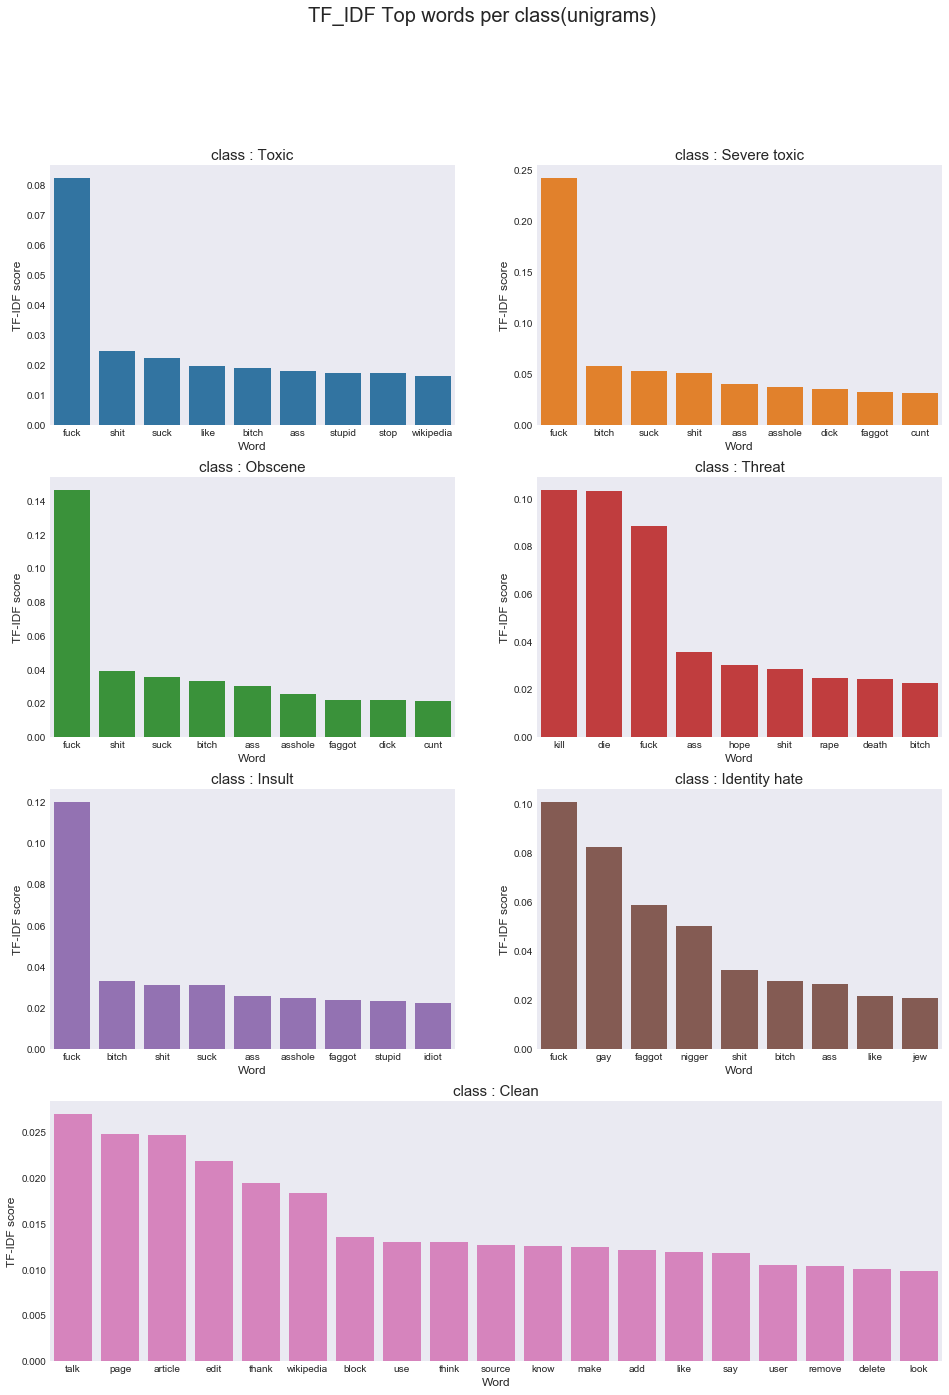

In [47]:
plt.figure(figsize=(16,22)) #figure size
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20) #title of all the plots
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0)) #plot region
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
#taking the first ten records of first index in tfidf_top_n_per_lass which has all the values of 
#tfidf_top_n_per_lass contains the words present in each type of attribute and their respective tf-idf score
#x-axis is the feature names and y-axis is the respective tf-idf score

plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19],color=color[6])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.savefig("tf-idf_unigrams")
plt.show()

Just like we have visualized unigrams the below code is to understand Bi-grams and visualise them

### Visualizing Bi-grams

In [49]:
#temp settings to min=150 to facilitate top features section to run in kernals
#change back to min=10 to get better results
#creating a tfidf vectorizer with different codings

tfv = TfidfVectorizer(min_df=10,  max_features=3000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus) #fitting the tfidfvectorizer to the whole dataset
features = np.array(tfv.get_feature_names()) #taking the names of the features learned in tfv.fit(clean_corpus) 

train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]]) #taking the records of training data and transforming
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)
# Return a list of dfs, where each df holds top_n features and their mean tfidf value
#        calculated across documents with the same class label. '''

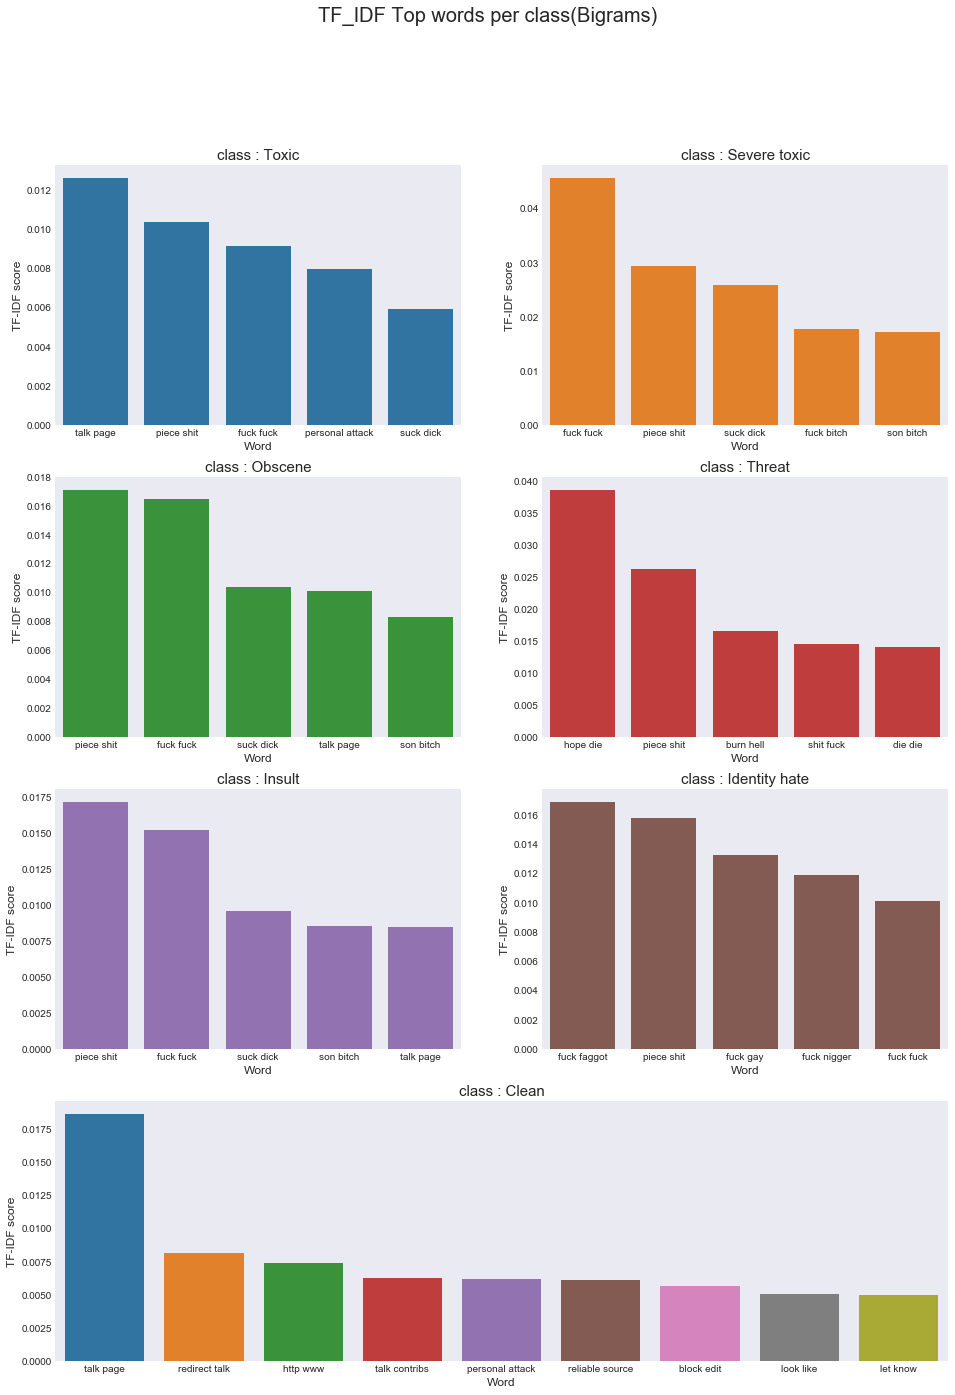

In [50]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.savefig("bigram_tf-idf_score")
plt.show()

In [51]:
end_time=time.time()
print("total time till bigrams",end_time-start_time)

total time till bigrams 907.9313719272614


In [57]:
del tfv

In [58]:
del train_charngrams

In [59]:
del test_charngrams

In [48]:
tfv = TfidfVectorizer(min_df=100,  max_features=30000, 
            strip_accents='unicode', analyzer='char',ngram_range=(1,4),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_charngrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_charngrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
end_time=time.time()
print("total time till charngrams",end_time-start_time)

total time till charngrams 2404.242551803589



# Baseline Model:

In [60]:
#Credis to AlexSanchez https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb#261316
#custom NB model

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    
# model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)


In [61]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]

# target_x
TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train_tags[TARGET_COLS]

# Strat k fold due to imbalanced classes
# split = StratifiedKFold(n_splits=2, random_state=1)

#https://www.kaggle.com/yekenot/toxic-regression

In [66]:
#Just the indirect features -- meta features
print("Using only Indirect features")
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

end_time=time.time()
print("total time till Indirect feat model",end_time-start_time)

Using only Indirect features


MemoryError: 

IndexError: list index out of range

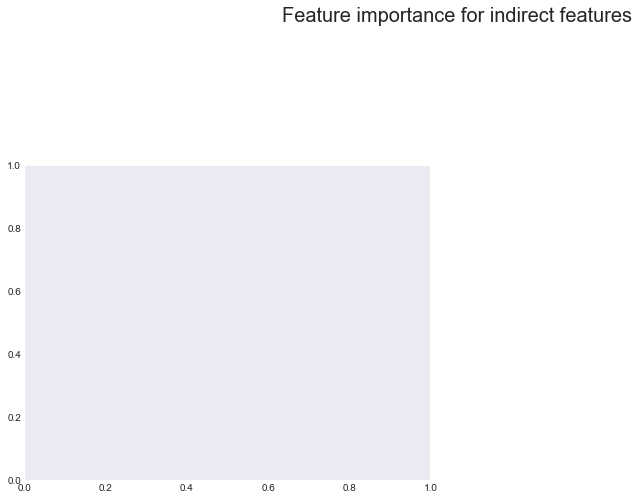

In [54]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()

In [55]:
from scipy.sparse import csr_matrix, hstack

#Using all direct features
print("Using all features except leaky ones")
target_x = hstack((train_bigrams,train_charngrams,train_unigrams,train_feats[SELECTED_COLS])).tocsr()


end_time=time.time()
print("total time till Sparse mat creation",end_time-start_time)

Using all features except leaky ones


NameError: name 'train_bigrams' is not defined

In [56]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("total time till NB base model creation",end_time-start_time)

MemoryError: 

# Topic Modeling: 

Topic modeling can be a useful tool to summarize the context of a huge corpus(text) by guessing what the "Topic" or the general theme of the sentence. 

This can also be used as inputs to our classifier if they can identify patterns or "Topics" that indicate toxicity.

Let's find out!

The steps followed in this kernel:
* Preprocessing (Tokenization using gensim's simple_preprocess)
* Cleaning
    * Stop word removal
    * Bigram collation
    * Lemmatization
*  Creation of dictionary (list of all words in the cleaned text)
* Topic modeling using LDA
* Visualization with pyLDAviz
* Convert topics to sparse vectors
* Feed sparse vectors to the mode

In [60]:
#import required packages
#basic
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
import pyLDAvis.gensim
#nlp
import string
import re     #for regex
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary


#Modeling
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from scipy import sparse

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")

#constants
eng_stopwords = set(stopwords.words("english"))
#settings
warnings.filterwarnings("ignore")
lem = WordNetLemmatizer()
tokenizer=ToktokTokenizer()


%matplotlib inline

C:\Users\NIT-BGDT\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [61]:
start_time=time.time()
#importing the dataset
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
end_import=time.time()
print("Time till import:",end_import-start_time,"s")

Time till import: 2.0732481479644775 s


In [62]:
#to seperate sentenses into words
def preprocess(comment):
    """
    Function to build tokenized texts from input comment
    """
    return gensim.utils.simple_preprocess(comment, deacc=True, min_len=3)


In [63]:
#tokenize the comments
train_text=train.comment_text.apply(lambda x: preprocess(x))
test_text=test.comment_text.apply(lambda x: preprocess(x))
all_text=train_text.append(test_text)
end_preprocess=time.time()
print("Time till pre-process:",end_preprocess-start_time,"s")

Time till pre-process: 78.95570254325867 s


In [64]:
#checks
print("Total number of comments:",len(all_text))
print("Before preprocessing:",train.comment_text.iloc[30])
print("After preprocessing:",all_text.iloc[30])

Total number of comments: 312735
Before preprocessing: How could I post before the block expires?  The funny thing is, you think I'm being uncivil!
After preprocessing: ['how', 'could', 'post', 'before', 'the', 'block', 'expires', 'the', 'funny', 'thing', 'you', 'think', 'being', 'uncivil']


In [65]:
#Phrases help us group together bigrams :  new + york --> new_york
bigram = gensim.models.Phrases(all_text)

In [66]:
#check bigram collation functionality 
bigram[all_text.iloc[30]]

['how',
 'could',
 'post',
 'before',
 'the',
 'block_expires',
 'the',
 'funny_thing',
 'you',
 'think',
 'being_uncivil']

In [67]:
def clean(word_list):
    """
    Function to clean the pre-processed word lists 
    
    Following transformations will be done
    1) Stop words removal from the nltk stopword list
    2) Bigram collation (Finding common bigrams and grouping them together using gensim.models.phrases)
    3) Lemmatization (Converting word to its root form : babies --> baby ; children --> child)
    """
    #remove stop words
    clean_words = [w for w in word_list if not w in eng_stopwords]
    #collect bigrams
    clean_words = bigram[clean_words]
    #Lemmatize
    clean_words=[lem.lemmatize(word, "v") for word in clean_words]
    return(clean_words)    

In [68]:
#check clean function
print("Before clean:",all_text.iloc[1])
print("After clean:",clean(all_text.iloc[1]))

Before clean: ['aww', 'matches', 'this', 'background', 'colour', 'seemingly', 'stuck', 'with', 'thanks', 'talk', 'january', 'utc']
After clean: ['aww', 'match', 'background', 'colour', 'seemingly', 'stick', 'thank', 'talk', 'january_utc']


In [69]:
#scale it to all text
all_text=all_text.apply(lambda x:clean(x))
end_clean=time.time()
print("Time till cleaning corpus:",end_clean-start_time,"s")

Time till cleaning corpus: 226.91477012634277 s


In [70]:
#create the dictionary
dictionary = Dictionary(all_text)
print("There are",len(dictionary),"number of words in the final dictionary")

There are 322843 number of words in the final dictionary


In [71]:
#convert into lookup tuples within the dictionary using doc2bow
print(dictionary.doc2bow(all_text.iloc[1]))
print("Wordlist from the sentence:",all_text.iloc[1])
#to check
print("Wordlist from the dictionary lookup:", 
      dictionary[21],dictionary[22],dictionary[23],dictionary[24],dictionary[25],dictionary[26],dictionary[27])

[(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
Wordlist from the sentence: ['aww', 'match', 'background', 'colour', 'seemingly', 'stick', 'thank', 'talk', 'january_utc']
Wordlist from the dictionary lookup: aww match background colour seemingly stick thank


In [72]:
#scale it to all text
corpus = [dictionary.doc2bow(text) for text in all_text]
end_corpus=time.time()
print("Time till corpus creation:",end_clean-start_time,"s")

Time till corpus creation: 226.91477012634277 s


In [73]:
#create the LDA model
ldamodel = LdaModel(corpus=corpus, num_topics=15, id2word=dictionary)
end_lda=time.time()
print("Time till LDA model creation:",end_lda-start_time,"s")

Time till LDA model creation: 906.1593029499054 s


In [74]:
pyLDAvis.enable_notebook()

In [75]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      15.679058        1       1  0.218798  0.042455
0      15.487488        1       2  0.248656  0.049563
12     15.379872        1       3  0.228293 -0.107416
8      10.669587        1       4  0.161225 -0.148459
7       6.179979        1       5  0.060586  0.184202
13      5.929659        1       6  0.113049  0.165023
1       4.509136        1       7 -0.049175  0.208704
9       4.239460        1       8  0.036279  0.054378
11      4.123007        1       9 -0.040338 -0.237793
3       3.828157        1      10  0.006046 -0.205272
2       3.163014        1      11 -0.083493  0.127752
4       2.818206        1      12 -0.151595 -0.172505
14      2.795620        1      13 -0.257170  0.099087
6       2.698229        1      14 -0.280208  0.081326
10      2.499527        1      15 -0.210955 -0.141044, topic_info=       Category           Freq                 Term          Total  loglift  \
term                                                                          
71      Default  124547.000000              article  124547.000000  30.0000   
79      Default   62692.000000            wikipedia   62692.000000  29.0000   
85      Default   60201.000000                 page   60201.000000  28.0000   
805     Default   22908.000000                 fuck   22908.000000  27.0000   
1       Default   48695.000000                 edit   48695.000000  26.0000   
132     Default   16494.000000                image   16494.000000  25.0000   
88      Default   49481.000000                  use   49481.000000  24.0000   
27      Default   36251.000000                thank   36251.000000  23.0000   
3629    Default   12674.000000            fuck_fuck   12674.000000  22.0000   
15      Default   36842.000000               please   36842.000000  21.0000   
199     Default   33390.000000               source   33390.000000  20.0000   
418     Default   35659.000000                  get   35659.000000  19.0000   
603     Default   18006.000000                block   18006.000000  18.0000   
198     Default   28372.000000                  add   28372.000000  17.0000   
291     Default   15837.000000           discussion   15837.000000  16.0000   
48      Default   20844.000000              section   20844.000000  15.0000   
1182    Default   24883.000000                 name   24883.000000  14.0000   
211030  Default   11877.000000             wtf_omfg   11877.000000  13.0000   
187     Default   20212.000000                 link   20212.000000  12.0000   
262     Default   44717.000000                 like   44717.000000  11.0000   
164     Default   17212.000000               delete   17212.000000  10.0000   
2167    Default   13047.000000                 user   13047.000000   9.0000   
235864  Default    8111.000000            phck_hole    8111.000000   8.0000   
16      Default   22292.000000               remove   22292.000000   7.0000   
214     Default   44553.000000                  see   44553.000000   6.0000   
55      Default   16538.000000            reference   16538.000000   5.0000   
44258   Default    7455.000000            cunt_cunt    7455.000000   4.0000   
780     Default   19357.000000              comment   19357.000000   3.0000   
54      Default   47734.000000                think   47734.000000   2.0000   
77      Default   18357.000000                 list   18357.000000   1.0000   
...         ...            ...                  ...            ...      ...   
3126    Topic15     433.242117                  mum     434.136180   3.6870   
8623    Topic15     432.590658             bastards     433.484722   3.6870   
210256  Topic15     417.330960         english_fool     418.235047   3.6869   
14957   Topic15     388.597112                  sie     389.491176   3.6868   
1972    Topic15     387.094982                 scar     387.989567   3.6868   
6038    Topic15     379.141261       

In [77]:
end_viz=time.time()
print("Time till viz:",end_viz-start_time,"s")

Time till viz: 6076.091031074524 s


**Chart Desc:** 

The above visuals are from the awesome pyLDAviz package which is the python version of R package LDAviz.

The Left side shows the multi-dimensional "word-space" superimposed on two "Principal components" and the relative positions of all the topics.

The size of the circle represents what % of the corpus it contains.

The right side shows the word frequencies within the topic and in the whole corpus.

Clearly, some of the topics show a pattern of toxicity (ie) have a high contribution from toxic words.

Now let's feed these topics into a model.

In [78]:
#creating the topic probability matrix 
topic_probability_mat = ldamodel[corpus]

In [79]:
#split it to test and train
train_matrix=topic_probability_mat[:train.shape[0]]
test_matrix=topic_probability_mat[train.shape[0]:]

In [80]:
del(topic_probability_mat)
del(corpus)
del(all_text)
gc.collect()

264

In [81]:
#convert to sparse format (Csr matrix)
train_sparse=gensim.matutils.corpus2csc(train_matrix)
test_sparse=gensim.matutils.corpus2csc(test_matrix)
end_time=time.time()
print("total time till Sparse mat creation",end_time-start_time,"s")

total time till Sparse mat creation 6425.503189563751 s


In [82]:
#custom NB model
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    

model = NbSvmClassifier(C=2, dual=True, n_jobs=-1)

In [83]:
#set the target columns
target_x=train_sparse.transpose()
TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train[TARGET_COLS]

In [84]:
del(train_sparse)
gc.collect()

16

In [87]:
X_valid[:,1]

<52659x1 sparse matrix of type '<class 'numpy.float64'>'
	with 24055 stored elements in Compressed Sparse Row format>

In [92]:
gh = model.predict(X_valid)[:,1]

IndexError: too many indices for array

In [98]:
m = model.predict(X_valid)

In [101]:
len(set(m))

2

In [104]:
from collections import Counter

words = ['a', 'b', 'c', 'a']

Counter(m).keys() # equals to list(set(words))
Counter(m).values() # counts the elements' frequency

dict_values([51611, 1048])

In [105]:
X_valid[:,1]

<52659x1 sparse matrix of type '<class 'numpy.float64'>'
	with 24055 stored elements in Compressed Sparse Row format>

In [90]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1) #initializing the model
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018) #splitting the model
#into train and test by 77 and 33%
train_loss = [] # creating an empty list for saving training loss
valid_loss = [] # creating list for saving validatiion loss
preds_train = np.zeros((X_train.shape[0], y_train.shape[1])) #creating an empty prediction of train data dimension
preds_valid = np.zeros((X_valid.shape[0], y_train.shape[1]))
for i, j in enumerate(TARGET_COLS): #creating a loop for predicting each column of Y
    print('Class:= '+j) 
    model.fit(X_train,y_train[j]) #fitting the model
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1] #predicting the probability on valid data
    preds_train[:,i] = model.predict_proba(X_train)[:,1] #predicting the probabilit on train data
    train_loss_class=log_loss(y_train[j],preds_train[:,i]) #saving the difference and loss of training data
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i]) #
    
    from sklearn.metrics import confusion_matrix
    
    #gh = model.predict(X_valid)[:,1]
    #m = metrics.confusion_matrix(model.predict(X_valid),X_valid[:,1] )
    #print(m)
    
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("total time till NB base model creation",end_time-start_time)

Class:= toxic


TypeError: len() of unsized object

In [451]:
import math
i=0
for i in range(len(train_loss)):
    print(math.exp(-train_loss[i])

0.8049445184809623
0.9636923867885527
0.8730423561203243
0.983671309933783
0.8729961918308683
0.9636276730380013


In [452]:
#credits
#pyLDAviz
#https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

#to be continued 
#to do next
#paragraph vectors
#https://arxiv.org/abs/1507.07998
#https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb